# REDE NEURAL 

Rede Neural Artificial (RNA), mais especificamente, uma MLP (Multi-Layer Perceptron) implementada com o MLPClassifier do scikit-learn.

MLP = Multi-Layer Perceptron:
- É uma rede neural densa (fully connected) com:
- Uma camada de entrada com o número de neurônios igual ao número de variáveis
- Duas camadas ocultas:
    - Ou seja, 32 neurônios na primeira camada e 16 na segunda

# Dúvidas Iniciais sobre o Tipo de IA a Ser Usada

## A IA precisa primeiro aprender o que é euploide/aneuploide (classificação binária), antes de tentar prever uma porcentagem (regressão)?  
O que seria o ideal, cientificamente falando?

---

## Etapa 1 — Classificação Binária (Euploide vs. Aneuploide)

Ensinar a IA a distinguir embriões euploides de aneuploides, com base em dados morfocinéticos e morfológicos:

- Euploide → `1`  
- Aneuploide → `0`

Objetivo: Forçar a IA a aprender os padrões fundamentais associados à saúde genética do embrião.

Analogia: É como ensinar uma criança o que é "gato" e "cachorro" antes de pedir que ela diga "o quão felino esse animal parece".

---

## Etapa 2 — Regressão (Previsão de Porcentagem de Euploidia)

Somente após dominar a classificação, a IA poderia tentar prever a porcentagem de euploidia, como por exemplo:

- 92%, 67%, 41%...

Importante: Essa abordagem só é viável se você tiver dados contínuos reais de porcentagem — por exemplo:

- Resultados de testes genéticos que indicam grau de mosaicismo ou frações de euploidia.

---

## Alternativa Mais Inteligente (Prática e Robusta)

Se os dados de porcentagem forem raros ou pouco confiáveis, o melhor caminho é:

Ficar na classificação binária:
- Euploide → `1`  
- Aneuploide → `0`

Isso evita problemas com overfitting e aumenta a robustez científica e clínica da IA.

# Análise Inicial dos Dados

## O que temos
- 82 linhas (embriões)
- 20 variáveis de entrada
- 1 coluna alvo: `Ploidia` (0 = Aneuploide, 1 = Euploide)
- Todas as variáveis já estão em formato numérico (incluindo Estágio, Morfo, Kidscore, etc.)
- As colunas estão coerentes e bem estruturadas para um modelo de classificação

---

### 1. Devo normalizar os dados?

Para **redes neurais**, sim, é altamente recomendado.

Redes neurais são sensíveis a escalas diferentes. Como há variáveis com escalas muito distintas (por exemplo, tempos como `t2`, `tSC`, `tB`, que vão de 0 a 100+, e outras como `Morfo`, de 1 a 4), isso pode causar desbalanceamento nos gradientes durante o aprendizado.

**Solução:**  
Normalizar todas as features (exceto `Ploidia`) usando `MinMaxScaler` ou `StandardScaler`.

---

### 2. A classificação de Estágio e Morfo está correta?

As transformações são úteis
- **Estágio:** converteu D5 e D6 para valores numéricos (5 e 6), o que é correto.
- **Morfo:** agrupou em 4 níveis com a função `classificar_morfo`, o que também é adequado e informativo.

**Kidscore:**
- Já está contínuo e varia de 1 a 9, o que indica que está possivelmente normalizado ou padronizado.
- Não é necessário reclassificar (ex: "ruim", "bom")

**Conclusão:**  
Deixar `Kidscore` como variável contínua.

---

### 3. Precisa balancear as classes (`Ploidia`)?

É importante contar os valores de `Ploidia` (0 e 1) para verificar o balanceamento:

- Se estiver desbalanceado (por exemplo, 90% de um tipo), o modelo pode acabar aprendendo apenas a prever a classe majoritária.

## Resultado da Contagem das Classes na Coluna `Ploidia`

| Classe         | Quantidade |
|----------------|------------|
| 1 (Euploide)   | 41         |
| 0 (Aneuploide) | 41         |

### Conclusão

As classes estão perfeitamente balanceadas.

Não é necessário aplicar técnicas de balanceamento (como oversampling, undersampling ou SMOTE).

In [34]:
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install openpyxl

In [31]:
import sys
print(sys.executable)

c:\Users\maria.ferreira\AppData\Local\Programs\Python\Python310\python.exe



=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

           0       0.62      0.89      0.73         9
           1       0.75      0.38      0.50         8

    accuracy                           0.65        17
   macro avg       0.68      0.63      0.61        17
weighted avg       0.68      0.65      0.62        17



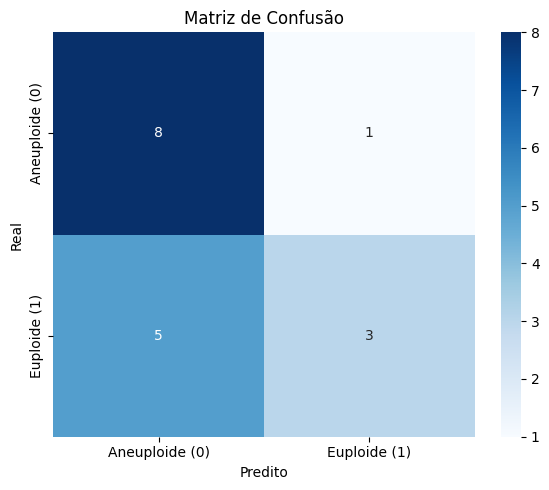

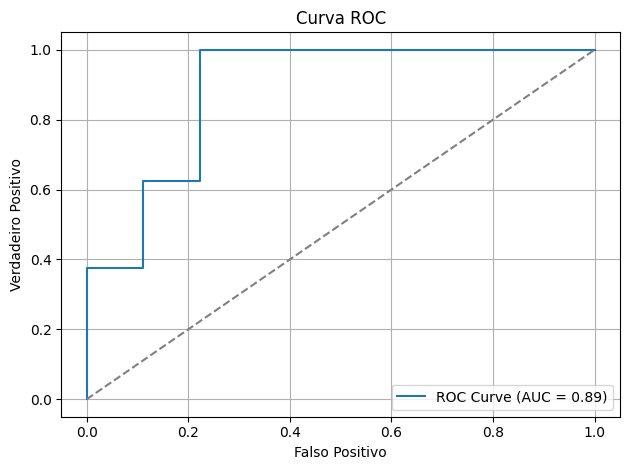

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carregar dados
df = pd.read_excel("PlanilhaNumerica.xlsx")

# 2. Separar entrada (X) e alvo (y)
X = df.drop(columns=["Ploidia"])
y = df["Ploidia"]

# 3. Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Divisão em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 5. Criar e treinar o modelo
modelo = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, activation='relu', solver='adam', random_state=42)
modelo.fit(X_train, y_train)

# 6. Previsões
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]

# 7. Relatório de classificação
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))

# 8. Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Aneuploide (0)", "Euploide (1)"], yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

# 9. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()